# Тестовое задание Доктор 24

**Задача**: создать прогностическую модель рисков беременных.  
**Срок**: до 1 недели  
**Метрика**: решаете сами  
**Как сдавать**: ссылку на google colab с выводами. Обязательно вывести матрицу ошибок на тесте.  
**Особенности**: В последних ячейках необходимо вывести метрики и матрицу ошибок на трейне и тесте.  


Описание:
 - `Age`: Age in years when a woman is pregnant.   
 - `SystolicBP`: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.   
 - `DiastolicBP`: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
 - `BS`: Blood glucose levels is in terms of a molar concentration, mmol/L.
 - `HeartRate`: A normal resting heart rate in beats per minute.
 - `Risk Level`: Predicted Risk Intensity Level during pregnancy considering the previous attribute.


**Рекомендации по выбору метрики и как понять какая метрика нам в итоге нужна (базовые рассуждения)**

Приоритизация полноты (Recall):

Пропуск случаев может иметь серьезные последствия, поэтому минимизация ложных отрицаний важна.

Баланс между точностью и полнотой (F1-Score):

Для балансировки между минимизацией ложных срабатываний и ложных отрицаний можно использовать F1-Score.

Использование матрицы ошибок (Confusion Matrix):

Оно нам нужно для понимания, какие классы наиболее проблематичны, и анализа, где происходят ошибки.


In [ ]:
# pip install catboost
# pip install optuna
# pip install xgboost
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import TPESampler
from tqdm.notebook import trange, tqdm

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Загрузим датасет
file_path = '/content/Maternal Health Risk Data Set.csv'
data = pd.read_csv(file_path)

In [ ]:
class_counts = data['RiskLevel'].value_counts()
print(class_counts)

# Коэффициент дисбаланса
imbalance_ratio = class_counts.max() / class_counts.min()
print(f'Коэффициент дисбаланса: {imbalance_ratio:.2f}')

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64
Коэффициент дисбаланса: 1.49


Коэффициент дисбаланса 1.49,это хорошее распределение коэффициэнтов, балансировку производить нет смысла.

In [ ]:
# Закодировать целевую переменую
label_encoder = LabelEncoder()
data['RiskLevel'] = label_encoder.fit_transform(data['RiskLevel'])

In [ ]:
# Добавление дополнительных фич
# в этом примере добавим старородящих и матерей-тинэйджеров
data['OldBirth'] = np.where(data['Age'] > 40, 1, 0)
data['EarlyBirth'] = np.where(data['Age'] < 20, 1, 0)

# Разделение данных на признаки и целевую переменную
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']

In [ ]:
# разделить на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Всем модели для обучения
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [ ]:
# Обучить все модели
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Get the classification report and confusion matrix for train set
    train_report = classification_report(y_train, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
    train_matrix = confusion_matrix(y_train, y_train_pred)

    # Get the classification report and confusion matrix for test set
    test_report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, output_dict=True)
    test_matrix = confusion_matrix(y_test, y_test_pred)

    results[name] = {
        'model': model,
        'train_report': train_report,
        'train_matrix': train_matrix,
        'test_report': test_report,
        'test_matrix': test_matrix,
        'test_accuracy': accuracy_score(y_test, y_test_pred)
    }


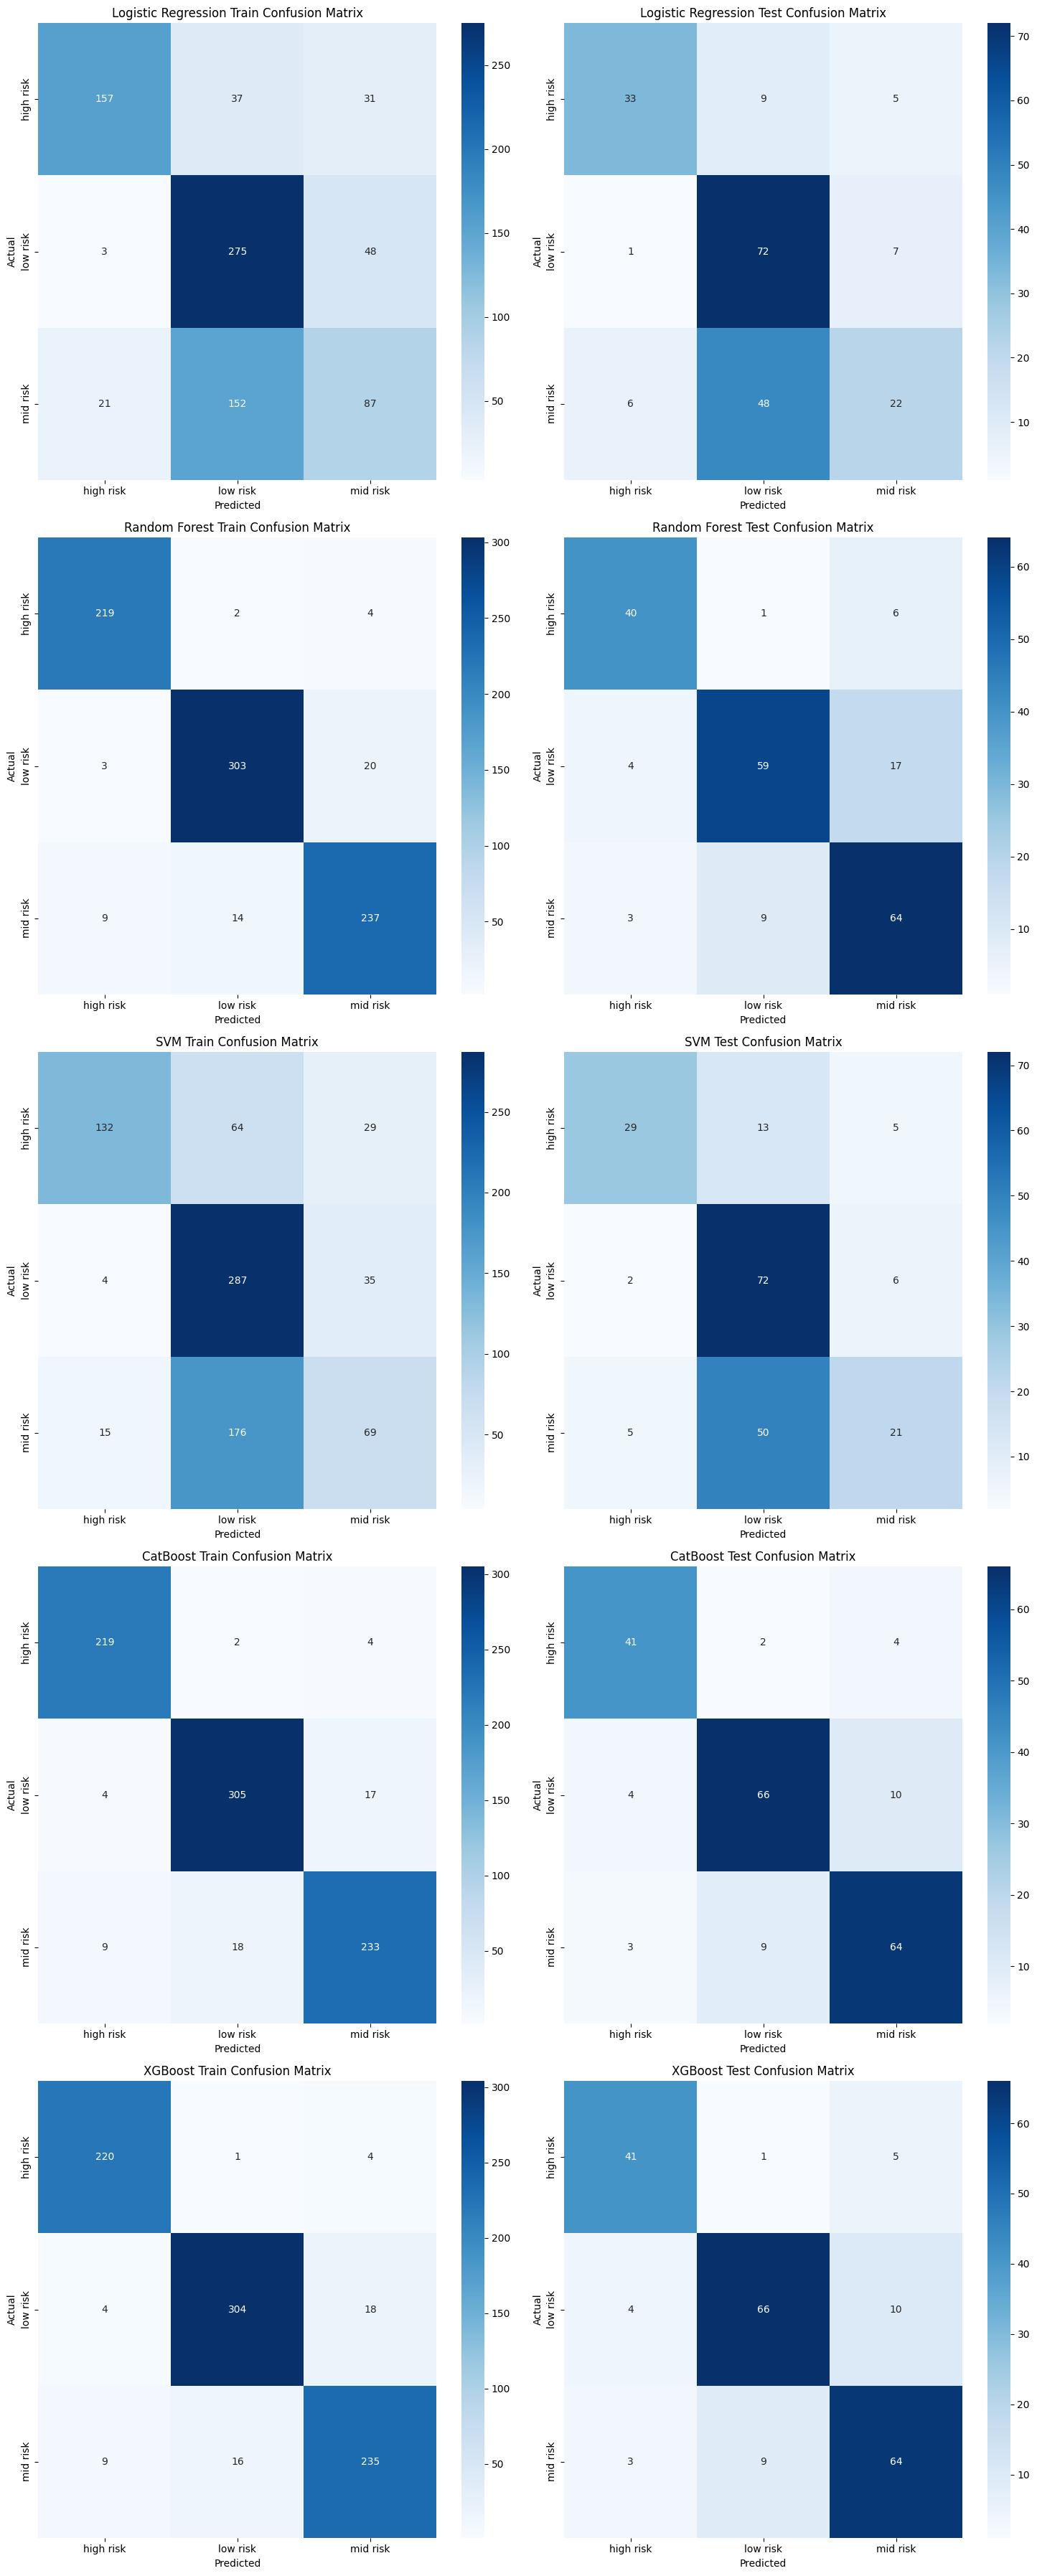

In [ ]:
# Построить матрицы ошибок
fig, axes = plt.subplots(5, 2, figsize=(15, 36))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    sns.heatmap(result['train_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx * 2], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axes[idx * 2].set_title(f'{name} Train Confusion Matrix')
    axes[idx * 2].set_xlabel('Predicted')
    axes[idx * 2].set_ylabel('Actual')

    sns.heatmap(result['test_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx * 2 + 1], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axes[idx * 2 + 1].set_title(f'{name} Test Confusion Matrix')
    axes[idx * 2 + 1].set_xlabel('Predicted')
    axes[idx * 2 + 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


classification_reports = {name: {'train': result['train_report'], 'test': result['test_report']} for name, result in results.items()}
reports_df = pd.DataFrame(classification_reports)

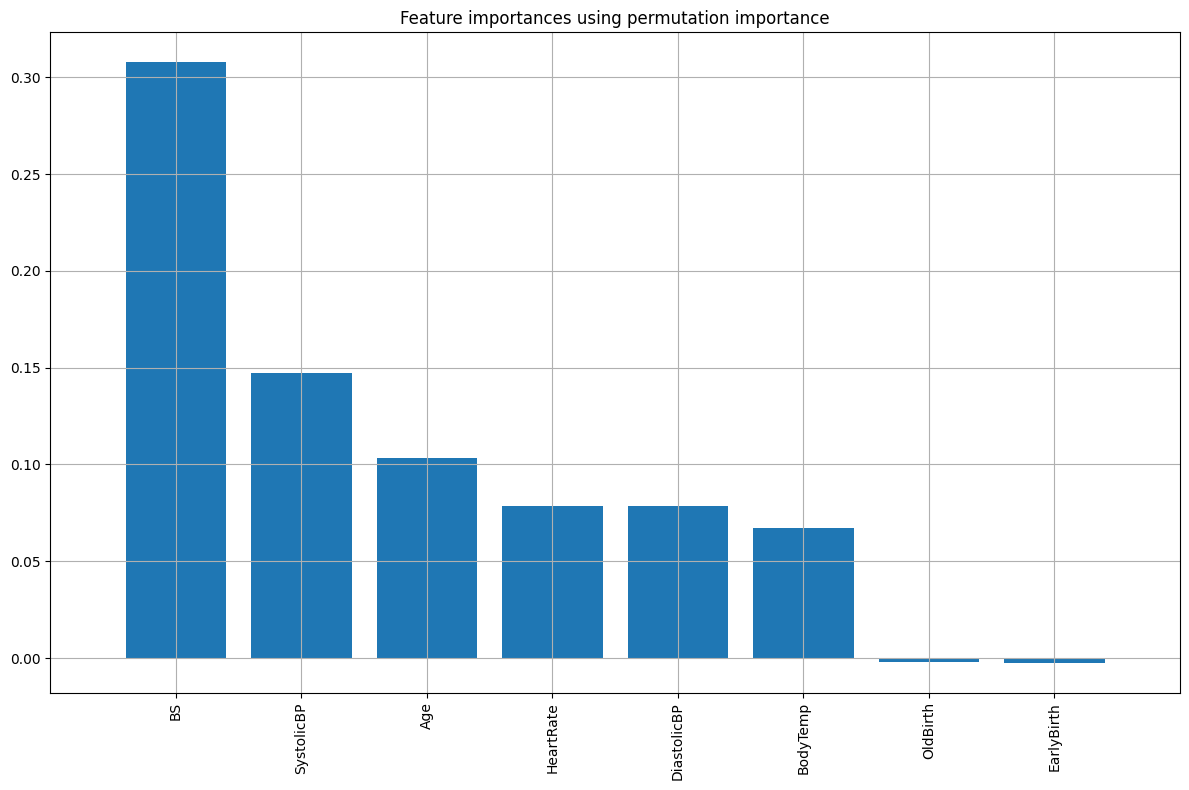

Best model: CatBoost with accuracy 0.8424


In [ ]:
# Выбрать лучшую модель по аккураси
best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']

perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42)

# Посмотрим на важность признаков
feature_names = X.columns
importances = perm_importance.importances_mean
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances using permutation importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.grid()
plt.show()

print(f"Best model: {best_model_name} with accuracy {results[best_model_name]['test_accuracy']:.4f}")


In [ ]:
#Как мы видим - уровень сахара это наиболее значимая фича наряду с давлением которая оказывает влияние на целевую переменную

In [ ]:
#Датафрейм со всеми метриками для более подробного изучения


,Logistic Regression,Random Forest,SVM,CatBoost,XGBoost
train,{'high risk': {'precision': 0.8674033149171271...,"{'high risk': {'precision': 0.948051948051948,...",{'high risk': {'precision': 0.8741721854304636...,{'high risk': {'precision': 0.9439655172413793...,"{'high risk': {'precision': 0.944206008583691,..."
test,"{'high risk': {'precision': 0.825, 'recall': 0...","{'high risk': {'precision': 0.851063829787234,...",{'high risk': {'precision': 0.8055555555555556...,{'high risk': {'precision': 0.8541666666666666...,{'high risk': {'precision': 0.8541666666666666...


No charts were generated by quickchart


In [ ]:
reports_df.T

,train,test
Logistic Regression,{'high risk': {'precision': 0.8674033149171271...,"{'high risk': {'precision': 0.825, 'recall': 0..."
Random Forest,"{'high risk': {'precision': 0.948051948051948,...","{'high risk': {'precision': 0.851063829787234,..."
SVM,{'high risk': {'precision': 0.8741721854304636...,{'high risk': {'precision': 0.8055555555555556...
CatBoost,{'high risk': {'precision': 0.9439655172413793...,{'high risk': {'precision': 0.8541666666666666...
XGBoost,"{'high risk': {'precision': 0.944206008583691,...",{'high risk': {'precision': 0.8541666666666666...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Определение функции для оптимизации и использование лучшей модели (в данном случае по Accuracy XGBoost)
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': len(set(y_train)),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = XGBClassifier(**param)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# Создание исследования и запуск оптимизации с прогресс-баром
study = optuna.create_study(direction='maximize', sampler=TPESampler())
n_trials = 1000

with tqdm(total=n_trials) as pbar:
    def objective_with_callback(trial):
        result = objective(trial)
        pbar.update(1)
        return result

    study.optimize(objective_with_callback, n_trials=n_trials)

# Вывод лучших гиперпараметров и точности
print(f'Лучшие гиперпараметры: {study.best_params}')
print(f'Лучший результат точности: {study.best_value:.4f}')

# Обучение модели с лучшими гиперпараметрами
best_params = study.best_params
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss')
best_model.fit(X_train, y_train)

# Оценка модели на тестовой выборке
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность на тестовой выборке: {accuracy:.4f}')

[I 2024-06-10 10:39:37,470] A new study created in memory with name: no-name-4489420d-530e-4c91-ab0d-888d5d94b01b


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-06-10 10:39:39,474] Trial 0 finished with value: 0.7681973486401531 and parameters: {'n_estimators': 79, 'max_depth': 4, 'learning_rate': 0.11414906219563571, 'subsample': 0.9785152674706294, 'colsample_bytree': 0.7749709553535513, 'gamma': 0.06235959190555811, 'min_child_weight': 5}. Best is trial 0 with value: 0.7681973486401531.
[I 2024-06-10 10:39:39,725] Trial 1 finished with value: 0.796551409958544 and parameters: {'n_estimators': 86, 'max_depth': 8, 'learning_rate': 0.1967699790443366, 'subsample': 0.6420056031490031, 'colsample_bytree': 0.648115832417537, 'gamma': 0.29120618660649145, 'min_child_weight': 1}. Best is trial 1 with value: 0.796551409958544.
[I 2024-06-10 10:39:40,501] Trial 2 finished with value: 0.7866748667486675 and parameters: {'n_estimators': 264, 'max_depth': 10, 'learning_rate': 0.03951431205252656, 'subsample': 0.6011522484306479, 'colsample_bytree': 0.6350838651380898, 'gamma': 0.16952634919810033, 'min_child_weight': 2}. Best is trial 1 with val

Лучшие гиперпараметры: {'n_estimators': 278, 'max_depth': 12, 'learning_rate': 0.02315713846022283, 'subsample': 0.9998788219116329, 'colsample_bytree': 0.8929748291203816, 'gamma': 0.05388377622467041, 'min_child_weight': 1}
Лучший результат точности: 0.8237
Точность на тестовой выборке: 0.8325


Как улучшить модель :



1.   Feature Engeneering ( создать новые признаки - от комбинаций текущих до простых функций от них по типу логарифма и так далее )
2.   Попробовать Стекинг и Блендинг ( для этой задачи это оверкилл )
3. Покрутить параметры в Оптуне подольше и поменять границы

